这堂课我们将学习如何使用Python进行面向对象式编程（Object-Oriented Programming，简称OOP）。我们将通过实现一个简单的量化交易策略，来深入理解OOP这种编程范式的强大之处。通过这堂课，你将掌握如下知识点。

1. 使用Python进行OOP的基本语法。包括类（class）、实例（instance）、属性（attribute）以及方法（method）等知识点。
2. 如何从OOP的角度进行思考，设计复杂问题的解决方案。
3. 使用Python进行OOP的高级语法。包括`__repr__`、`__call__`等特殊方法的使用，以及`@property`装饰器的使用等进阶知识点。

In [62]:
import pandas as pd
from pathlib import Path
from datetime import datetime, timedelta

In [63]:
# pd.__version__

# 问题描述

我们将实现一个简单的基于趋势跟随（Trend Following）的股票交易策略（Trading Strategy）。该策略通过判断一只股票的当前价格是否高于（低于）其近期的均值水平，来决定是否买入（卖出）该股票。我们将基于该策略，构造一个投资组合（Portfolio），并通过回测（backtest）该Portfolio的历史表现，来评估策略的有效性。

思考：如何拆解该问题？

1. Portfolio是由股票构成的资产集合，它是一系列股票买卖交易的结果。那么，如何存储单支股票的数据？
2. 基于个股数据，便可以进行模拟交易。所谓构建Portfolio，本质上是追踪一系列股票交易行为。那么，如何存储交易数据？
3. 基于一个Portfolio的交易数据，可以计算该Portfolio在任意时间点的持仓数据。结合个股数据，便可以计算该Portfolio在该时间点的资产价值。
4. 交易策略，可以抽象地理解为一个根据给定规则生成交易数据的算法。那么，该如何设计这个算法？

接下来，让我们先关注第一个问题，并学习如何基于OOP的思想来设计解决方案。

不过在正式开始OOP的学习之前，让我们先来准备些股票的历史数据。

In [64]:
# Fetch real-world stock data
stock_symbols = ["AAPL", "MSFT", "GOOGL", "BA", "WBA", "INTC"]
start_date = "2020-01-01"
end_date = "2024-10-31"

save_path = Path('./stock_data')  # save it into the stock_data's directory
save_path.mkdir(exist_ok=True)
resave = False

"""
the program we write will be opened and excuted for many times,so we need to initialize the data-saving&cleaning pipeline
"""
stock_data = {}               
for symbol in stock_symbols:
    save_as = save_path/f"{symbol}.csv"
    if not save_as.is_file() or resave:
        try:
            import yfinance as yf
            stock_df = yf.download(symbol, start=start_date, end=end_date)
            stock_df = stock_df.droplevel(level='Ticker', axis=1)
            stock_df.columns.name = None
            stock_df.index.name = None
            stock_df.index = stock_df.index.tz_localize(None) #removing timezones information from the index
            stock_df.to_csv(save_as, index=True) # save the clean stock data
        except ImportError:
            # Install the required library
            # !pip install yfinance
            raise ImportError('The "yfinance" has not been installed!')
    else:
        stock_df = pd.read_csv(save_as, index_col=0, parse_dates=True) # now the datetime will be the index column
    dates = [datetime.strptime(date.strftime('%Y-%m-%d'), '%Y-%m-%d') for date in stock_df.index]  # 1st: using strftime to convert timestamps to YYYY-MM-DD string format,removing irrelavent information like timezone; 2nd: converting string back to datetime format but only with y,m,d
    prices = stock_df["Adj Close"].to_list() # convert the"Adj Close"(adjusted close) column into a list
    # we only extract the data we want which is adjusted close price
    stock_data[symbol] = dict(zip(dates, prices))  # Maps each date to its corresponding adjusted Closing price and store it in a dictionary
    # now stock_data is a nested dictionary which key is symbol, value is a dict

In [65]:
for i, (k, v) in enumerate(stock_data['AAPL'].items()):
    print(k, v, type(k), type(v), sep=' | ')
    if i >= 2:
        break

2020-01-02 00:00:00 | 72.87610626220703 | <class 'datetime.datetime'> | <class 'float'>
2020-01-03 00:00:00 | 72.16758728027344 | <class 'datetime.datetime'> | <class 'float'>
2020-01-06 00:00:00 | 72.74266052246094 | <class 'datetime.datetime'> | <class 'float'>


我们将每支股票的数据，存储为一个字典。该字典的每个条目中，键（key）是一个时间日期，表示一个交易日；值（value）是该股票在该交易日的收盘价格，可以用来近似交易策略中可以执行的买卖价格。

In [66]:
k

datetime.datetime(2020, 1, 6, 0, 0)

注意到，每个key的类型为`datetime.datetime`。用OOP的术语来说，每个key是`datetime.datetime`类的一个实例（instance）。

通过这个例子，你可以总结出类和实例的一般定义么？

注意，在OOP的相关资料中，会频繁使用对象（object）这一术语。大部分情况下，可以将object理解为instance的同义词。

# 定义`Stock`类

考虑到不同的股票都有相同的数据字段，我们可以定义`Stock`类，来一般性地描述一支股票应该包含的数据以及支持的操作。下面的代码声明了`Stock`类，请阅读该代码来理解以下知识点。

1. 如何声明一个类？
2. 如何定义一个类的实例化方法，即`__init__`方法？
3. 什么是以及如何定义实例属性（attribute）和实例方法（method）？
4. 如何理解实例方法中的`self`参数？

In [67]:
# Define the Stock class
class Stock:
    
    def __init__(self, name, ticker, historical_prices):
        # ticker might change over time, `name` is intended to hold the permenant name of a stock
        self.name = name
        self.ticker = ticker
        self.historical_prices = historical_prices  # Dictionary of {date: price}
        self.trading_dates = sorted(historical_prices.keys())  # Only store valid trading dates
    
    def get_price(self, date):
        return self.historical_prices.get(date, None) # use dict.get(key,default) to fectch the prices from self.historical_prices

In [68]:
symbol = 'AAPL'
stock_aapl = Stock(symbol, symbol, stock_data[symbol])

In [69]:
stock_aapl

In [70]:
# stock_aapl.trading_dates

In [71]:
stock_aapl.get_price(datetime(2024, 2, 1, 0, 0))

186.15362548828125

In [72]:
stock_aapl.historical_prices[stock_aapl.trading_dates[0]] #dict[key]

72.87610626220703

按照如下方案进一步完善`Stock`类。


1. 定义实例方法`__getitem__`，用它替换原来的实例方法`get_price`，让查询股票历史价格变得更加方便。
2. 定义实例方法`__repr__`，更直观地展示`Stock`对象的内容。
3. 定义实例方法`get_trading_dates_in_range`，返回一个给定日期范围内的交易日。该功能会在Porfolio的价值评估中用到。
4. 将之前加载股票数据的代码封装到函数`get_stock_data`中。
5. 定义**类**属性`default_stock_data`和**类**方法`from_ticker`和，让根据股票ticker实例化`Stock`对象更加方便。注意观察函数`get_stock_data`是在何时被运行的。

请阅读下方代码，学习并掌握上述知识点。


In [73]:
def get_stock_data(stock_symbols=["AAPL", "MSFT", "GOOGL", "BA", "WBA", "INTC"], start_date="2020-01-01", end_date="2024-10-31", save_path='./stock_data', resave=False):
    print('... fetching real-world stock data ...')

    save_path = Path(save_path)
    save_path.mkdir(exist_ok=True)

    stock_data = {}
    for symbol in stock_symbols:
        save_as = save_path/f"{symbol}.csv"
        if not save_as.is_file() or resave:
            try:
                import yfinance as yf
                stock_df = yf.download(symbol, start=start_date, end=end_date)
                stock_df = stock_df.droplevel(level='Ticker', axis=1)
                stock_df.columns.name = None
                stock_df.index.name = None
                stock_df.index = stock_df.index.tz_localize(None)
                stock_df.to_csv(save_as, index=True)
            except ImportError:
                # Install the required library
                # !pip install yfinance
                raise ImportError('The "yfinance" has not been installed!')
        else:
            stock_df = pd.read_csv(save_as, index_col=0, parse_dates=True)
        dates = [datetime.strptime(date.strftime('%Y-%m-%d'), '%Y-%m-%d') for date in stock_df.index]
        prices = stock_df["Adj Close"].to_list()
        stock_data[symbol] = dict(zip(dates, prices))
    
    return stock_data

In [74]:
class Stock:
    
    # make `default_stock_data` a private attribute
    __default_stock_data = get_stock_data()
    # alternatively, make `default_stock_data` a public attribute
#     default_stock_data = get_stock_data()
    
    def __init__(self, name, ticker, historical_prices):
        # ticker might change over time, `name` is intended to hold the permenant name of a stock
        self.name = name
        self.ticker = ticker
        self.historical_prices = historical_prices  # Dictionary of {date: price}
        self.trading_dates = sorted(historical_prices.keys())  # Only store valid trading dates
    
    # we have tow dtypes: int + datetime for indexes
    def __getitem__(self, idx):   # __getitem__ a magical method: define behavior for indexing
        if isinstance(idx, int):
            return self.historical_prices[self.trading_dates[idx]] # now trading_dates is a list
        elif isinstance(idx, datetime):
            return self.historical_prices.get(idx, None) # we use datetime as key in dict historical_prices directly
        else:
            raise NotImplementedError(f"Unknown index type {type(idx)}!")
            
    def __repr__(self): # class representation
        # get the startdate and its value
        k0 = self.trading_dates[0]   
        v0 = self.historical_prices[k0]
        k0_str = k0.strftime('%Y-%m-%d')
        # get the end date and ...
        k1 = self.trading_dates[-1]
        v1 = self.historical_prices[k1]
        k1_str = k1.strftime('%Y-%m-%d')
        return f"name:{self.name}|ticker:{self.ticker}|data:{{{k0_str}:{v0:.2f}, ..., {k1_str}:{v1:.2f}}}"

    def get_trading_dates_in_range(self, start_date, end_date):
        # Filter trading dates within the specified date range
        return [date for date in self.trading_dates if start_date <= date <= end_date]
    
    @classmethod
    def from_ticker(cls, symbol, stock_data=None):
        if stock_data is None:
            stock_data = cls.__default_stock_data
        return cls(symbol, symbol, stock_data[symbol])

... fetching real-world stock data ...


测试功能

In [75]:
# Stock.default_stock_data

In [76]:
symbol = 'AAPL'
stock_aapl = Stock(symbol, symbol, stock_data[symbol])

In [77]:
stock_aapl[0]

72.87610626220703

In [78]:
stock_aapl[stock_aapl.trading_dates[0]]

72.87610626220703

In [79]:
# stock_aapl['a']

In [80]:
stock_aapl.get_trading_dates_in_range(stock_aapl.trading_dates[-3], stock_aapl.trading_dates[-1])

[datetime.datetime(2024, 10, 28, 0, 0),
 datetime.datetime(2024, 10, 29, 0, 0),
 datetime.datetime(2024, 10, 30, 0, 0)]

In [81]:
stock_aapl = Stock.from_ticker('AAPL') # using the classmethod to call __repr__ to represent the class
stock_aapl

name:AAPL|ticker:AAPL|data:{2020-01-02:72.88, ..., 2024-10-30:230.10}

最后，我们简要学习下如何使用自定义模块（module）组织代码。

具体而言，定义模块`trade`及其子模块`stock`，并将函数`get_stock_data`以及类`Stock`的代码放入其中。另外，我们还进一步完善了`Stock`的实现，为其添加了如下功能：
+ 使用字符串格式的日期进行价格查找。
+ 找到某个时间点之前最近一次的交易日。
+ 可视化。

后续章节中，我们将频繁使用该方案组织代码。另外，使用[VS Code](https://code.visualstudio.com/)或者任意支持Python语言的IDE（Integrated Develop Environment）打开这个jupyter notebook，可以极大简化源码查看的流程。

为了展示将代码按模块组织的优势，我们先将前面格子中定义的相关变量全部删除，留下一个干净的命名空间。

In [82]:
# del stock_data
for varname in ['stock_data', 'start_date', 'end_date', 
        'symbol', 'save_path', 'resave', 'dates', 'prices', 
        'Stock', 'get_stock_data']:
    try:
        del globals()[varname] # global()is a built-in Python function that returns a dictionary of all variables and functions: keys are variable names(as strings), and the values are the corresponding objects
    except KeyError:
        pass

In [83]:
# start_date

导入相关的模块。

In [85]:
%load_ext autoreload

In [86]:
%autoreload 2

In [87]:
# import matplotlib.pyplot as plt
from trade import Stock
# from trade import get_stock_data

... fetching real-world stock data ...


In [88]:
stock_aapl = Stock.from_ticker('AAPL')
stock_aapl

name:AAPL|ticker:AAPL|data:{2020-01-02:72.88, ..., 2024-10-30:230.10}

<Axes: title={'center': 'Price of AAPL from 2023-01-01 to 2023-12-31'}, xlabel='Date', ylabel='Price'>

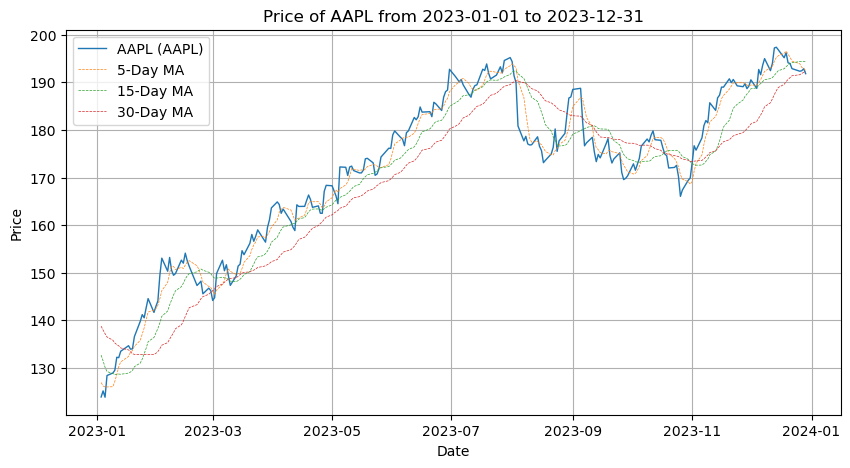

In [89]:
stock_aapl.visualize(datetime(2023,1,1), datetime(2023,12,31), k_values=[5, 15, 30])

是不是在jupyter notebook中写的代码简洁了很多？后续章节，将默认你正在使用VS Code阅读这个notebook。

# 定义`Portfolio`类

回忆我们之前的分析：

    ...
    2. 基于个股数据，便可以进行模拟交易。所谓构建Portfolio，本质上是追踪一系列股票交易行为。那么，如何存储交易数据？
    3. 基于一个Portfolio的交易数据，可以计算该Portfolio在任意时间点的持仓数据。结合个股数据，便可以计算该Portfolio在该时间点的资产价值。
    ...
    
思考：如何基于OOP的思想，实现上述需求？

请利用你从`Stock`类的实现中学到的知识，设计`Portfolio`类。具体而言，需实现如下功能。

1. 属性：
    + 现金（`cash`）
    + 持仓信息（`holdings`）
    + 交易历史（`trade_history`）

2. 方法：
    + 转入现金（`deposit_cash`）
    + 买单支股票（`buy_stock`）
    + 卖单支股票（`sell_stock`）
    + 基于当前持仓，估计任意时间点**当前**持有资产的总价值（`get_value_c`）
    + 回溯交易历史，估计任意时间点**历史**持有资产的总价值（`get_value_h`）
    
思考：`holdings`和`trade_history`该用什么数据结构存储？实现`buy_stock`和`sell_stock`时该注意哪些事项？实现`get_value_h`时，该如何使用`trade_history`中的信息？

请阅读下方代码，学习并掌握以下几个知识点：

+ `buy_stock`的实现逻辑
+ `holding_stocks`的实现方法及意义
+ `get_averge_holding_cost`以及`__repr__`的实现细节

In [90]:
class Portfolio:
    def __init__(self):
        self.cash = 0
        self.holdings = {} # dtype: nested dict
        self.trade_history = [] # dtype: list

    def deposit_cash(self, amount):
        self.cash += amount

    def buy_stock(self, stock, quantity, date):
        price = stock[date]        
        total_cost = price * quantity
        self.cash -= total_cost
        if stock.name in self.holdings:
            self.holdings[stock.name]["quantity"] += quantity
        else:
            self.holdings[stock.name] = {"stock": stock, "quantity": quantity}
        self.trade_history.append(('buy', stock.name, quantity, date, price))
    
    def sell_stock(self, stock, quantity, date):
        price = stock[date]
        total_revenue = price * quantity
        self.cash += total_revenue
        self.holdings[stock.name]["quantity"] -= quantity
        if self.holdings[stock.name]["quantity"] == 0:
            del self.holdings[stock.name]
        self.trade_history.append(('sell', stock.name, quantity, date, price))
        
    @property # used to define a read-only property in a class,meaning the method it decorates behaves like an attribute rather than a method,without parentheses
    def holding_stocks(self):
        return list(self.holdings.keys())
    
    def get_average_holding_cost(self, stock_name, verbose=False):
        buy_records = [
            # (quantity, price)
            (action[2], action[4]) for action in self.trade_history # action[2] is quantity ; action[4]is price | [(q_0,p_0),(q_1,p_1),(,)...]
            if (action[0]=='buy') and (action[1]==stock_name)]
        cash_outflow = sum([q*p for q, p in buy_records])
        quant_inflow = sum([q for q, _ in buy_records]) # only to get the quantity

        sell_records = [
            # (quantity, price)
            (action[2], action[4]) for action in self.trade_history 
            if (action[0]=='sell') and (action[1]==stock_name)]
        cash_inflow = sum([q*p for q, p in sell_records])
        quant_outflow = sum([q for q, _ in sell_records])
        
        value_net = cash_outflow - cash_inflow
        quant_net = quant_inflow - quant_outflow
        average_cost = value_net/quant_net
        
        if verbose:
            return average_cost, value_net, quant_net
        else:
            return average_cost
        
    def __repr__(self):
        cash_info = f"cash: {self.cash:.2f}"
        asset_info_l = [cash_info]
        total_value = self.cash
        for stock_name in self.holding_stocks:
            avg_price, total_cost, quant = self.get_average_holding_cost(stock_name, verbose=True) # when verbose = True, we offer more information(net cost, net quantity)
            asset_info_l.append(f"{stock_name}: {total_cost:.2f}={quant}*{avg_price:.2f}")
            total_value += total_cost
        asset_info_l.append(f"total: {total_value}")
        asset_info = ' | '.join(asset_info_l)
        return asset_info + " (net cost perspective)"

功能测试

In [91]:
portfolio = Portfolio()
portfolio.deposit_cash(1000)
stock_aapl = Stock.from_ticker('AAPL')
stock_msft = Stock.from_ticker('MSFT')
# portfolio.buy_stock(stock_aapl, 10, datetime.strptime('2023-1-1', '%Y-%m-%d'))
# portfolio.buy_stock(stock_aapl, 20, datetime.strptime('2023-1-5', '%Y-%m-%d'))
portfolio.buy_stock(stock_aapl, 5, stock_aapl.trading_dates[0])
portfolio.buy_stock(stock_msft, 2, stock_msft.trading_dates[0])
portfolio.sell_stock(stock_aapl, 1, stock_aapl.trading_dates[5])
# @error 1, uncomment the code below
# portfolio.buy_stock(stock_msft, 1, datetime(2023, 1, 1, 0, 0))
# @error 2, uncomment the code below
# portfolio.sell_stock(stock_aapl, 6, stock_aapl.trading_dates[10])
# @error 3, uncomment the code below
# portfolio.sell_stock(stock_msft, 1, stock_msft.trading_dates[-1])
portfolio

cash: 402.87 | AAPL: 289.25=4*72.31 | MSFT: 307.88=2*153.94 | total: 1000.0 (net cost perspective)

In [92]:
portfolio.trade_history

[('buy', 'AAPL', 5, datetime.datetime(2020, 1, 2, 0, 0), 72.87610626220703),
 ('buy', 'MSFT', 2, datetime.datetime(2020, 1, 2, 0, 0), 153.93821716308594),
 ('sell', 'AAPL', 1, datetime.datetime(2020, 1, 9, 0, 0), 75.12776947021484)]

上面实现的`Portfolio`类有如下缺陷。

1. 对于买卖的边界情形未加判断。具体来说，输入的日期可能并非交易日，导致价格为空；买入所需资金可能大于当前已有的资金；卖出的数量可能大于当前持有的数量。注意到，后两者情况程序并不会报错。参考注释“@error 1”和“@error 2”。另外，我们没有强制约束每笔交易必须在时间上发生在所有已执行的交易之后，这在逻辑上不合理。
2. 无法自定义买入卖出的价格。毕竟，通过查询`Stock`对象得到的价格，只是对于当天可能的成交价格的近似。实际交易价格可能与之不同。
3. 某一只股票的平均持仓成本（`get_average_holding_cost`）的计算逻辑有待商榷。当卖出价远大于买入价时，平均持有成本可能为负数。参考注释“@error 3”。该如何理解这种结果？注意到，股票资产的收益或亏损分两种情况：“已实现盈亏”和“未实现盈亏”（即浮盈浮亏）。当一支股票的平均持有成本为负数时，代表在该股票上的总卖出收益大于总投入成本，多出的部分代表了已实现盈利的一部分，这部分盈利已经计入到现金池中。
4. 注意到，`get_average_holding_cost`的计算逻辑无法帮助我们观察到已实现亏损。这是因为我们做的是发生在某只股票上的总流入资金与总流出资金的匹配，而没有精确到每个卖出单位与每个买入单位的匹配。这导致我们无法核算出每个卖出单位造成的盈亏。那么，该如何实现买卖数据单位级别的匹配呢？即如何回答，卖出的某一单位股票，究竟在卖的是哪笔买入交易中的一单位股票？为了回答这一问题，我们将股票持仓视为库存（inventory），采取**最大化已实现亏损**的原则进行成本核算。即卖出一单位股票时，优先卖出**已有的买的最贵**的那单位股票。考虑到已实现亏损的金额可以用来抵税，而已实现盈利的金额则可能需要缴税，这种核算原则有利于投资人的利益最大化。当然，也有其它核算原则，这里就不展开了。
5. 采用上述原则重新实现`get_average_holding_cost`后，我们还要进一步丰富实例方法`__repr__`输出的信息，额外展示“未实现盈亏（Unrealized P&L）”以及“已实现盈亏（Realized P&L）”。
6. 记录交易数据时，我们采取的是“扁平化”的视图模式。所谓扁平视图（flat view），即所有的交易按照交易时间从过去到现在依次排列。这种视图有其优势，但统计个股交易情况时，还要进行转换，比较麻烦。与之形成对比的是，我们可以采取层级视图（hierarchical view）的模式，即按照个股分组结合买卖方向的形式，记录交易数据。注意到，基于hierarchical view版本的交易数据，总是可以动态推导出flat view版本的交易数据。我们可以利用`@property`来实现从前者到后者的转换过程。
7. 此外，我们还希望`Portfolio`类支持以下功能。
   1. 撤销最近的几次交易。
   2. 执行交易时，可选择是否打印交易信息。
   3. 记录追加现金的历史操作。

基于上面的分析思路，进一步完善`Portfolio`类。请阅读源码，重点学习实例方法`Portfolio.get_average_holding_cost`的实现思路，同时关注以下知识点。

1. 如何使用VS Code进行源码的阅读、编辑、运行（run）以及调试（debug）？
2. 应该在何时、何处以及如何进行[合理性检验](https://zh.wikipedia.org/zh/Sanity_check)（sanity check）？
3. 如何进行Type Hinting？在自动补全、语法检查等方面，使用Type Hinting相比于不使用的优势。
4. 如何使用`@dataclass`定义负责存储一组相关数据的简单容器？使用该容器，相比于使用字典、列表，有何优势？
5. 该如何设计每个函数的接口（interface），以最大限度地进行代码复用，同时让计算逻辑变得清晰易懂？比如，请留意`verbose`参数的含义和使用场景。


In [ ]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
# %load_ext autoreload
# %autoreload 2

In [93]:
from trade import Portfolio

功能测试

In [94]:
portfolio = Portfolio()
portfolio.deposit_cash(5000, datetime(2010,1,1))
stock_aapl = Stock.from_ticker('AAPL')
stock_msft = Stock.from_ticker('MSFT')
portfolio.buy_stock(stock_aapl, 5, 0)
portfolio.buy_stock(stock_msft, 2, 0)
portfolio.sell_stock(stock_aapl, 4, 1)
# the line below should raise an exception
# portfolio.buy_stock(stock_aapl, 2, 0)
portfolio.sell_stock(stock_msft, 1, 1)
portfolio.buy_stock(stock_aapl, 5, 5)
portfolio.sell_stock(stock_aapl, 2, 50)
portfolio.get_value_c(stock_aapl.trading_dates[100])

4996.134368896484

In [95]:
portfolio

Snapshot taken on: 2024-12-05
Lastly traded on: 2020-03-16
Cash: 4510.61
Stock:
       Cost  Price  QTY    P/L  Unrealized P/L  Realized P/L
AAPL  72.88 230.10    4 586.87          628.90        -42.03
MSFT 153.94 432.53    1 276.67          278.59         -1.92
Investment P&L: 863.54

上表中的数字应作如下解读。
1. "P/L"列展示了总盈亏。其含义是，如果在某个时间点按照"Price"列展示的市场价格清仓持有的某只股票，那么通过交易这只股票造成的总盈亏是多少。
   
   比如，对于"AAPL"这只股票，如果我们在距离今天之前最近的那个交易日，按照当时市场价格230.10，卖出当前持有的所有4单位股票（由"QTY"列给出），那么总利润为586.87。注意，"P/L"是净值。即综合考虑与"AAPL"相关的所有已发生的交易记录，以及最后尚未发生的这笔清仓交易，得到的总利润是586.87。
2. "Realized P/L"列展示了根据最大化已实现亏损（或者最小化已实现盈利）的原则，基于已发生的交易记录，计算的已实现盈亏（负值代表亏损）。
3. "Unrealized P/L"列展示了未实现盈亏，其计算公式为“总盈亏-已实现盈亏”。
4. "Cost"列展示了平均持有成本，其计算公式根据下述等式推算得到。
        
        未实现盈亏 =（市场价格(Price)-平均持有成本(Cost)）*当前持仓数量(QTY)

5. 最后展示的"Investment P&L"，由"P/L"列的数字加总得到，对应投资行为造成的总盈亏。

In [ ]:
print(portfolio.inspect_asset_value(before=datetime(2020, 3, 16)), end='\n\n')
# print(portfolio.inspect_asset_value(before=datetime(2020, 3, 16), favor_investor=False), end='\n\n')
print(portfolio.inspect_asset_value(before=datetime(2020, 12, 31)), end='\n\n')
portfolio.buy_stock(stock_aapl, 5, 100, verbose=True)
portfolio.sell_stock(stock_aapl, 3, 150, verbose=True)
print("If we want to do the investor a favor, then ...")
print(portfolio.inspect_asset_value(before=datetime(2020, 12, 31)), end='\n\n')
print("If we don't want to do the investor a favor, then ...")
print(portfolio.inspect_asset_value(before=datetime(2020, 12, 31), favor_investor=False), end='\n\n')
# print("If we hold the portfolio for 2 more year, then ...")
# print(portfolio.inspect_asset_value(before=datetime(2022, 12, 31)), end='\n\n')
print("If we hold the portfolio for 3 more years, then ...")
print(portfolio.inspect_asset_value(before=datetime(2023, 12, 31)), end='\n\n')

portfolio.undo_recent_transactions(2)

Snapshot taken on: 2020-03-16
Lastly traded on: 2020-03-16
Cash: 4510.61
Stock:
       Cost  Price  QTY    P/L  Unrealized P/L  Realized P/L
AAPL  72.88  58.91    4 -97.90          -55.87        -42.03
MSFT 153.94 130.14    1 -25.71          -23.80         -1.92
Investment P&L: -123.61

Snapshot taken on: 2020-12-31
Lastly traded on: 2020-03-16
Cash: 4510.61
Stock:
       Cost  Price  QTY    P/L  Unrealized P/L  Realized P/L
AAPL  72.88 129.89    4 186.05          228.07        -42.03
MSFT 153.94 215.43    1  59.57           61.49         -1.92
Investment P&L: 245.62

++++++++++++++++++++++++++++++++++++++++++++++++++++++++
buy 5 units of AAPL stock with price 77.58 on 2020-05-27
--------------------------------------------------------
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
sell 3 units of AAPL stock with price 111.11 on 2020-08-06
----------------------------------------------------------
If we want to do the investor a favor, then ...
Snapshot taken on: 2020-12-31

从上面的结果中，我们可以观察到如下事实。

1. 只要没有新的交易发生，已实现盈亏（Realized P&L）和平均持有成本（Cost）不随时间改变。考虑到它们都是基于已发生的交易核算得出，这很合理。
2. 即便没有新的交易发生，未实现盈亏（Unrealized P/L），即浮盈浮亏，也会随着股票价格的变动而发生同向的变动。因此，如果我们做一名价值投资者，长期持有一支股票的回报，会反应在未实现盈亏上。

## 练习1

深入探究平均持有成本和已实现盈亏的数学关系，我们可以得到如下结论。

给定一支股票，记它在$t$时刻的市场价格为$p_t$，对它的持仓为$Q_t$，平均持有成本为$c_t$。投资该股票的总盈亏为$\mathcal{P}_t$，已实现盈亏为$\mathcal{P}_t^{(r)}$，未实现盈亏为$\mathcal{P}_t^{(u)}$。统计已发生的交易，记因买入该股票而支出的总金额为$O_t$，因卖出该股票而赚得的总金额为$I_t$。

根据定义，我们有如下三个恒等式。

$$
\begin{align}
\mathcal{P}_t &= p_t Q_t + I_t - O_t \\
\mathcal{P}_t &= \mathcal{P}^{(r)} _t+ \mathcal{P}^{(u)}_t \\
\mathcal{P}^{(u)}_t &= (p_t-c_t) Q_t
\end{align}
$$

不难作出如下推导。

$$
\begin{align}
\mathcal{P}^{(r)}_t &= \mathcal{P}_t - \mathcal{P}^{(u)}_t \\
  &= p_t Q_t + I_t - O_t - (p_t-c_t) Q_t \\
  &= c_t Q_t + I_t - O_t
\end{align}
$$

注意到，只要没有新的交易发生，$Q_t$、$I_t$、$O_t$，都不会随着时间变化。因此，只要$c_t$的核算仅依赖历史交易信息，那么$\mathcal{P}^{(r)}_t$也将如此，因为二者可以互相推导。

不过，已实现盈亏竟然会依赖还未卖出的股票，似乎有点难以理解。我们可以换种方式来理解二者的关系。

统计已发生的交易中卖出股票的总数量，记为$Q_t^{(s)}$。直觉上，已实现盈亏应该是由这些卖出交易造成的。基于总卖出金额$I_t$和总卖出数量$Q_t^{(s)}$，可以定义平均卖出价格为$\bar{p}_t^{(s)}=I_t/Q_t^{(s)}$。那么，对应的平均买入成本$\bar{c}_t^{(b)}$是什么？注意到，我们可以对$\mathcal{P}^{(r)}_t$关于$c_t$的表达式进行如下变形。

$$
\begin{align}
\text{on the one hand,}& \\
\mathcal{P}^{(r)}_t &= c_t Q_t + I_t - O_t \\
  &= \bar{p}_t^{(s)}Q_t^{(s)} - (O_t-c_t Q_t)   \\
  &= \bar{p}_t^{(s)}Q_t^{(s)} - \frac{O_t-c_t Q_t}{Q_t^{(s)}} Q_t^{(s)}  \\
\text{on the other hand,}& \\
\mathcal{P}^{(r)}_t &= (\bar{p}_t^{(s)} - \bar{c}_t^{(b)}) Q_t^{(s)}
\end{align}
$$

不难发现，$\bar{c}_t^{(b)} = \frac{O_t-c_t Q_t}{Q_t^{(s)}}$。其中，分母是总卖出数量，而分子可以被解读成“总卖出数量对应的总买入成本”。在这个意义上，分子除以分母便得到了平均买入成本。总之，我们对于$c_t$的核算方式，决定了$\bar{c}_t^{(b)}$的取值，进而又决定了$\mathcal{P}^{(r)}_t$的取值。

在之前的核算方法中，我们通过库存匹配的思路，先确定$\mathcal{P}^{(r)}_t$，再推导出$c_t$。而基于之前的分析，我们也可以先核算出$c_t$，再推导出$\mathcal{P}^{(r)}_t$。下面，考虑一种简单的核算$c_t$的方案。

令$c_t$等于平均买入成本。具体来说，记历史交易中，一共买入了$Q_t^{(b)}$单位的股票，则$c_t=O_t/Q_t^{(b)}$。

请利用类的继承，实现这种核算方案。下面的代码已经给出了部分实现。

In [ ]:
from datetime import datetime
from trade import Portfolio
from trade.portfolio import analyze_trade_flow, StockPLData

class PortfolioA(Portfolio):
    
    def get_average_holding_cost(self, stock_name, before_date:datetime = None, favor_investor=True):
        buy_records = self.trade_history[stock_name]['buy']
        sell_records = self.trade_history[stock_name]['sell']
        flow_data = analyze_trade_flow(stock_name, buy_records, sell_records)
        market_price = self.get_market_price(stock_name, before_date) if flow_data.on_hand_QTY > 0 else 0
        # ------ 1. compute average holding cost ------
        average_cost = 0 # your code here
        # ------ 2. compute total P&L ------
        total_PL = self.compute_total_PL(market_price, flow_data)
        # ------ 3. compute unrealized P&L ------
        unrealized_PL = 0 # your code here
        # ------ 4. compute realized P&L ------
        realized_PL = 0 # your code here
        return StockPLData(average_cost, market_price, flow_data.on_hand_QTY, total_PL, unrealized_PL, realized_PL)

测试功能

In [ ]:
# your code below

# 实现交易策略

请阅读源码，关注以下知识点。

1. 实例方法`__call__`的含义。简单而言，当我们实现了一个类的`__call__`方法后，便可以将该类的实例视作函数进行调用。这样做有什么好处？
2. 交易策略核心逻辑的实现。请重点关注实例方法`TSTrendFollow.get_tradable_stocks`以及`TSTrendFollow.trade_tradable_stocks`的实现细节。

In [ ]:
from trade.strategy import TSTrendFollow
from trade.stock import annotate_transactions

In [ ]:
trend_follow_strategy = TSTrendFollow(epsilon_up=0, epsilon_down=0, 
        lookback_days=15, max_invest_ratio=1)
# trend_follow_strategy = TSTrendFollow(epsilon_up=0, epsilon_down=0)

# Initialize stock instances
pools_1 = ["AAPL", "MSFT"]
stocks = [Stock.from_ticker(symbol) for symbol in pools_1]

# Run the trend-following strategy
investment_amount = 1000
strategy_start_date = datetime.strptime("2023-01-01", "%Y-%m-%d")
strategy_end_date = datetime.strptime("2023-6-30", "%Y-%m-%d")

final_value = trend_follow_strategy(stocks, investment_amount, strategy_start_date, strategy_end_date, verbose=False)
# print(f"Final Portfolio Value: ${final_value:.2f}")

In [ ]:
print(trend_follow_strategy.portfolio.inspect_asset_value(strategy_end_date))

Snapshot taken on: 2023-06-30
Lastly traded on: 2023-06-07
Cash: 54.49
Stock:
       Cost  Price  QTY    P/L  Unrealized P/L  Realized P/L
AAPL 129.51 192.72    7 219.91          442.47       -222.56
MSFT   0.00   0.00    0 183.63           -0.00        183.63
Investment P&L: 403.54


In [ ]:
transact_df = pd.DataFrame(trend_follow_strategy.portfolio.trade_history_flat)
transact_df.to_csv('trade_history.csv')
transact_df.head(2)

,action,stock_name,q,p,t,idx,cash
0,deposit-e,cash,1,1000.000000,2023-01-01,1,1000.000000
1,buy,AAPL,7,129.511902,2023-01-10,2,93.416687


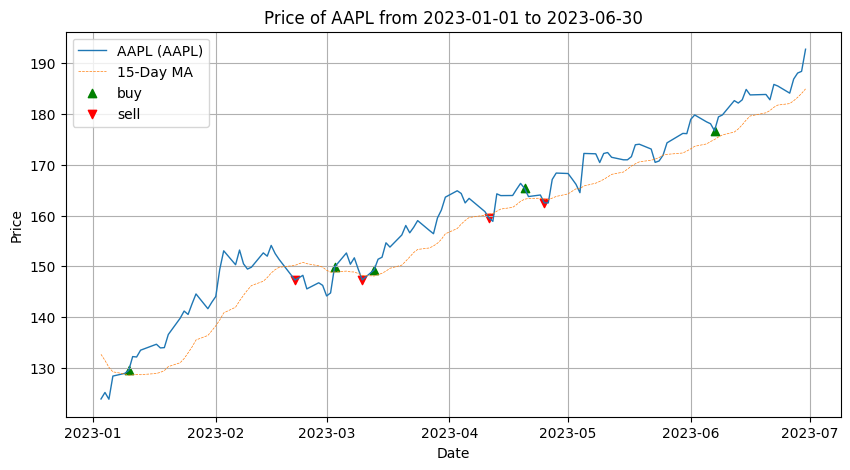

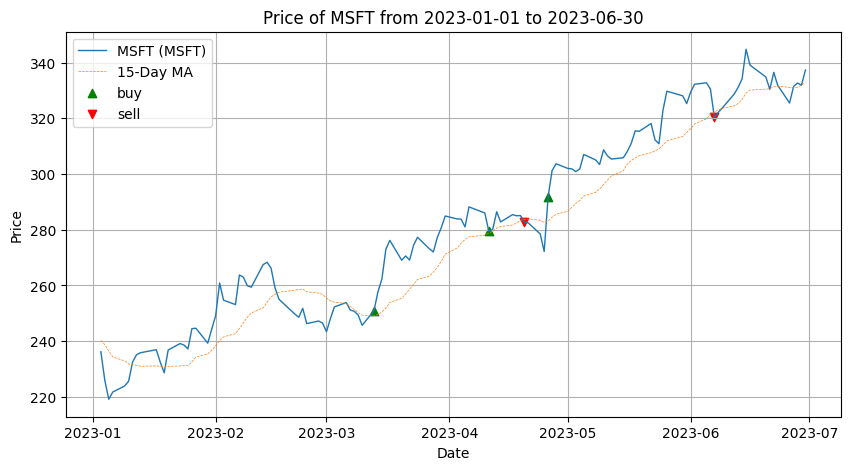

In [ ]:
for stock in stocks:
    ax = stock.visualize(strategy_start_date, strategy_end_date, 
        k_values=[trend_follow_strategy.lookback_days])
    is_stock = transact_df.stock_name == stock.name
    if is_stock.sum() > 0:
        annotate_transactions(ax, transact_df[is_stock])

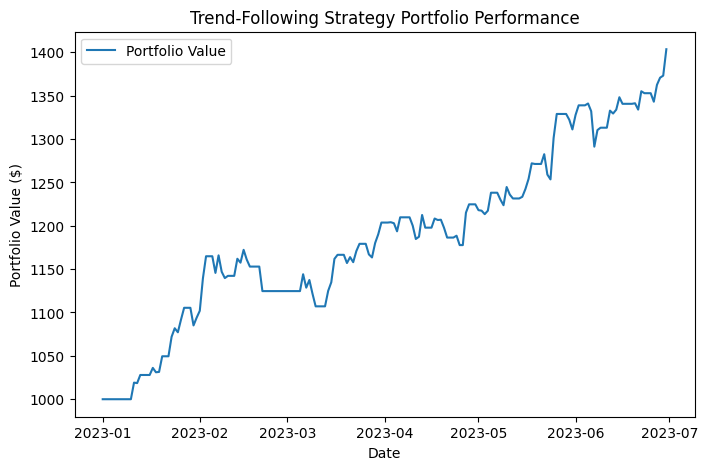

In [ ]:
portfolio_values = trend_follow_strategy.visualize_bt_results()

如果换一组股票池会如何？

Final Portfolio Value: $941.86


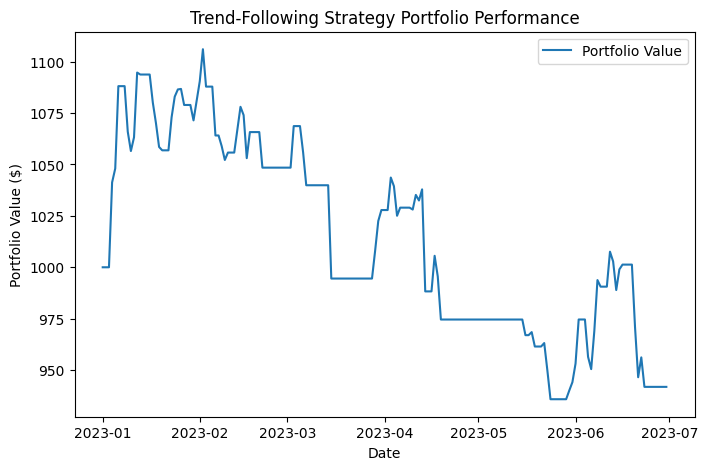

In [ ]:
trend_follow_strategy_2 = TSTrendFollow(lookback_days=15, epsilon_up=0, epsilon_down=0, max_invest_ratio=1)

pools_2 = ["BA", "WBA"]
stocks = [Stock.from_ticker(symbol) for symbol in pools_2]

# Run the trend-following strategy
final_value = trend_follow_strategy_2(stocks, investment_amount, strategy_start_date, strategy_end_date)
print(f"Final Portfolio Value: ${final_value:.2f}")

portfolio_values = trend_follow_strategy_2.visualize_bt_results()

## 练习2

利用已实现的功能，如何在整个投资周期$[T_s, T_e]$中分阶段调整策略？比如，时间段$[T_s, T_1]$内投资股票池A，时间段$[T_1, T_e]$内投资股票池B。

具体来说，假设在2020年1月1日，投资人决定投入5000美金进行股票买卖，股票池为`["GOOGL", "INTC"]`。然后在2021年1月1日，投资人决定追加5000块投资，并在下一个交易日，清空当前持仓，将股票池切换为`["AAPL", "MSFT"]`。


In [ ]:
# do not modify the code below
investment_amount_A = 5000
pools_A = ["GOOGL", "INTC"]
period_A = (datetime(2020,1,1), datetime(2020,12,31))

investment_amount_B = 5000
pools_B = ["AAPL", "MSFT"]
period_B = (datetime(2021,1,1), datetime(2022,12,31))

In [ ]:
# your code below

## 练习3

从某个时间点开始，假设我们有1000美金可以用来投资。那么，怎样交易哪些股票，会带来比较好的投资收益？比如，我们可以假设自己位于2021年1月1日这个时间点。我们想利用该时间点之前的股票价格数据，找到一个比较好的交易策略。然后基于找到的策略进行模拟交易，观察该策略在2021年1月1日到2021年12月31日这个时间段内的表现。

具体来说，基于已实现的趋势交易算法，和默认的股票数据，一个策略需要定义清楚如下细节。

1. 投资哪些股票？约定从默认股票池中进行选择（["AAPL", "MSFT", "GOOGL", "BA", "WBA", "INTC"]）。
2. 怎样设定策略的核心参数的取值？约定核心参数为：`lookback_days`、`epsilon_up`、`epsilon_down`。


最后，我们还要思考，基于多长的历史数据（2021年1月1日之前的数据）来评估一个策略的**预期**表现，比较合适？

解决思路：
1. 确定历史数据的长度以及交易算法核心参数的搜索空间。
2. 根据搜索空间中的每组`lookback_days`、`epsilon_up`、`epsilon_down`的**取值组合**，创建一个`TSTrendFollow`实例。完成后，得到一个由一系列交易算法实例构成的字典。
3. 从默认的股票池中选择若干子集，比如["AAPL", "MSFT"]、["GOOGL", "INTC"]、["AAPL", "MSFT", "GOOGL", "INTC"]等。
4. 对于每个可选的股票集合，利用第一步确定的历史数据，评估每个交易算法实例的表现。
5. 最后，找出表现最好的那对股票集合和交易算法实例，然后从2021年1月1日开始进行模拟交易，观察该策略在2021
年1月1日到2021年12月31日这个时间段内的表现。

请思考并回答：回测表现最好的策略，在未来也是表现最好的么？请用实验结果支持你的论证。

In [ ]:
# do not modify the code below
from itertools import chain, combinations, product
from datetime import datetime
from dataclasses import dataclass, asdict

from trade.stock import Stock
from trade.strategy import TSTrendFollow

In [ ]:
# do not modify the code below
@dataclass
class StrategyConfig:
    
    lookback_days: int
    epsilon_up: float
    epsilon_down: float
    
    def __iter__(self):
        return self.lookback_days, self.epsilon_up, self.epsilon_down

In [ ]:
# do not modify the code below
investment_amount = 1000

# Define the parameter search space
lookback_days_options = [5, 10, 15]
epsilon_up_options = [0.01, 0.05, 0.1]
epsilon_down_options = [0.01, 0.05, 0.1]

config_pools = list(map(lambda x: StrategyConfig(*x), 
    product(lookback_days_options, epsilon_up_options, epsilon_down_options)))

# Define the stock pool search space
stock_list = ["AAPL", "MSFT", "GOOGL", "BA", "WBA", "INTC"]
stock_pools = list(filter(lambda x: len(x)>0, chain.from_iterable(combinations(stock_list, r) 
        for r in range(len(stock_list)+1))))

# Define the historical period for strategy performance evaluation
historical_start_date = datetime(2020, 1, 1)
historical_end_date = datetime(2020, 12, 31)

# Define the simulation period
simulation_start_date = datetime(2021, 1, 1)
simulation_end_date = datetime(2021, 12, 31)

In [ ]:
# your code below

# 进一步探索

请思考以下问题：

+ 如何更全面的衡量根据某个策略构造的Portfolio的历史表现？比如，如何计算最大回撤？
+ 如何考虑止盈和止损？比如，在练习2的模拟交易中，如果我们能在2021年年底左右清仓，那么投资收益会大幅提升。
+ 如何构建并实现更进阶的交易策略？比如，如何应用Markowitz的投资组合理论（Portfolio Theory）？
+ 一般而言，每笔交易都会有交易费用，如通过券商进行买卖所需支付的佣金。频繁交易会带来较大的交易费用。那么，如何考虑交易费用？
+ 除了相对好确定的交易费用，每笔交易还会有额外的交易成本，且成因更复杂，金额更难提前确定。比如，实盘时，我们真的能像回测时假设的那样，以一个固定的市场价，买卖所有想交易的股票数量么？流动性好的股票，也许偏差不大，流动性差的股票则不然。为什么？那么，该如何考虑交易成本？

最后，给大家推荐一本关于量化投资的书：[http://www.mlfactor.com/index.html](http://www.mlfactor.com/index.html)。虽然书籍的主体部分的代码实现是基于R语言的，但[附录部分](http://www.mlfactor.com/python.html)也提供了对应的基于Python语言的实现。

## 练习4

请思考并指出现有交易策略的不足之处，以及相应的改进方案，最后编程实现你的方案。